In [1]:
import os
import sys
import gc
import json
import time
import datetime
import itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adamax, Adadelta, Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeNormal

 

In [ ]:
# to enable memory growth in GPU.
def setup_gpu():
    """
    Configures TensorFlow to use GPU efficiently by enabling memory growth.
    """
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
    
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)  # Prevents full memory allocation
            print("GPU memory growth enabled.")
        except RuntimeError as e:
            print(f"Error setting GPU memory growth: {e}")

In [2]:

class QuantumChromosome:
    def __init__(self, max_layers, num_classes, max_fc_layers, manual_layer_types=None):

        self.max_layers = max_layers
        self.num_classes = num_classes
        self.max_fc_layers = max_fc_layers
        self.dot_decimal_list = []  # To store dot-decimal values for each layer
        self.qubits_list = []  # To store initialized qubits for each layer
        self.binary_strings_list = []  # To store qubits collapsed/measured into  binary strings for each layer

        # Initialize the CNN layers with manual or random layer types
        self.initialize_CNN_layers(manual_layer_types)

    def initialize_CNN_layers(self, manual_layer_types):

        if manual_layer_types:
            if len(manual_layer_types) != self.max_layers:
                raise ValueError("Manual layer types list must match the number of max layers.")

            for idx, layer_type in enumerate(manual_layer_types):
                final_layer = (idx == self.max_layers - 1)  # Final layer is always fully connected
                self.init_layer(layer_type, final_layer)
        else:
            self.init_layer('Conv')  # First layer must be convolutional
            prev_layer = 'Conv'  # Keep track of the previous layer
        
            # Adding layers before the fully connected layers
            for _ in range(1, self.max_layers - self.max_fc_layers):
                if prev_layer == 'Pooling':
                    # If the previous layer was pooling, force Conv layer next
                    layer_type = 'Conv'
                else:
                    # Otherwise, allow Conv, Pooling, or Disabled
                    layer_type = np.random.choice(['Conv', 'Pooling', 'Disabled'], p=[0.5, 0.4, 0.1] if prev_layer!= 'Disabled' else [0.6,0.4,0]) 
                
                self.init_layer(layer_type)
                prev_layer = layer_type 

            # Adding fully connected layers
            disabled_used = False
            for _ in range(self.max_layers - self.max_fc_layers, self.max_layers - 1):
                if not disabled_used:
                    layer_type = np.random.choice(['FC', 'Disabled'], p=[0.8, 0.2])
                    if layer_type == 'Disabled':
                        disabled_used = True
                        
                else:
                    layer_type = 'FC'  # Force FC if 'Disabled' has already been used
        
                self.init_layer(layer_type)

            self.init_layer('FC', final_layer=True)  # Final layer is fully connected




    def init_layer(self, layer_type, final_layer=False):
        """
        Initialize a layer with qubits, collapse to binary, and encode to dot-decimal.
        """
        # Initialize qubits based on layer type
        if layer_type == 'Conv':
            qubits = self.init_convolution_qubits()
        elif layer_type == 'Pooling':
            qubits = self.init_pooling_qubits()
        elif layer_type == 'FC':
            qubits = self.init_fully_connected_qubits(final_layer=final_layer)
        else:  # Disabled
            qubits = self.init_disabled_qubits()


        self.qubits_list.append(qubits)   # Save the qubits for reference

        # Collapse qubits into binary string
        binary_string = ''.join(
            '0' if np.random.rand() < abs(alpha)**2 else '1'
            for alpha, beta in qubits
        )

        self.binary_strings_list.append(binary_string)  # Save binary string

        # Encode to dot-decimal and append to the architecture list
        dot_decimal_value = binary_to_dot_decimal(binary_string, layer_type)
        self.dot_decimal_list.append(dot_decimal_value)


    def random_qubit(self):
        alpha = np.random.uniform(-1, 1)
        beta = np.sqrt(1 - alpha**2) * (1 if np.random.rand() > 0.5 else -1)
        return [alpha, beta]

    def init_convolution_qubits(self):
        return np.array([self.random_qubit() for _ in range(12)])  # 12 bits for convolution

    def init_pooling_qubits(self):
        return np.array([self.random_qubit() for _ in range(11)])  # 11 bits for pooling

    def init_fully_connected_qubits(self, final_layer=False):
        return np.array([self.random_qubit() for _ in range(11)])  # 11 bits for Fc Layers

    def init_disabled_qubits(self):
        return np.array([self.random_qubit() for _ in range(11)])  # 11 bits for Disabled



# Dot-decimal encoding function with layer-specific padding
def binary_to_dot_decimal(binary_string, layer_type):
    # Add specific padding based on layer type
    if layer_type == "Conv":
        binary_string = "0000" + binary_string  # Padding for Conv layer
    elif layer_type == "Pooling":
        binary_string = "00010" + binary_string  # Padding for Pooling layer
    elif layer_type == "FC":
        binary_string = "00011" + binary_string  # Padding for Fully Connected layer
    elif layer_type == "Disabled":
        binary_string = "00100" + binary_string  # Padding for Disabled layer

    # Ensure binary_string is now 16 bits long
    binary_string = binary_string.zfill(16)

    # Split into two 8-bit chunks
    msb = binary_string[:8]
    lsb = binary_string[8:]

    # Convert each chunk to decimal
    msb_decimal = int(msb, 2)
    lsb_decimal = int(lsb, 2)


    # Combine MSB and LSB with a dot
    dot_decimal_value = float(f"{msb_decimal}.{lsb_decimal}")
    #print("TYPE",type(dot_decimal_value))
    return dot_decimal_value

def dot_decimal_to_binary_and_layer(dot_decimal_value):
    # Define the ranges for each layer type
    ranges = {
        "Conv": ((0, 15), (0, 255)),       # MSB range and LSB range for Convolutional layers
        "Pooling": ((16, 23), (0, 255)),   # MSB range and LSB range for Pooling layers
        "FC": ((24, 31), (0, 255)),        # MSB range and LSB range for Fully-Connected layers
        "Disabled": ((32, 39), (0, 255))   # MSB range and LSB range for Disabled layers
    }
    # Extract MSB and LSB from the dot-decimal value
    dot_decimal_str = str(dot_decimal_value)
    msb, lsb = map(int, dot_decimal_str.split("."))  # Separate MSB and LSB

    # Identify the layer type based on the dot-decimal value range
    layer_type = None
    for layer, ((msb_min, msb_max), (lsb_min, lsb_max)) in ranges.items():
        if msb_min <= msb <= msb_max and lsb_min <= lsb <= lsb_max:
            layer_type = layer
            break

    if layer_type is None:
        raise ValueError(f"Dot-decimal value {dot_decimal_value} does not match any layer type range.")

    # Convert the dot-decimal value back to binary
    dot_decimal_str = str(dot_decimal_value)

    # print(dot_decimal_str)
    msb, lsb = map(int, dot_decimal_str.split("."))  # Split into integers
    # print(lsb)
    # Convert MSB and LSB back to binary
    msb_binary = format(msb, '08b')  # Convert MSB to 8-bit binary
    lsb_binary = format(lsb, '08b')  # Convert LSB to 8-bit binary

    # Combine the binary components
    full_binary = msb_binary + lsb_binary  # Full 16-bit binary representation

    # Remove the layer-specific padding
    if layer_type == "Conv":
        final_binary = full_binary[4:]  # Remove "0000"
    elif layer_type == "Pooling":
        final_binary = full_binary[5:]  # Remove "00010"
    elif layer_type == "FC":
        final_binary = full_binary[5:]  # Remove "00011"
    elif layer_type == "Disabled":
        final_binary = full_binary[5:]  # Remove "00100"
    else:
        raise ValueError(f"Unexpected layer type: {layer_type}")

    return final_binary, layer_type



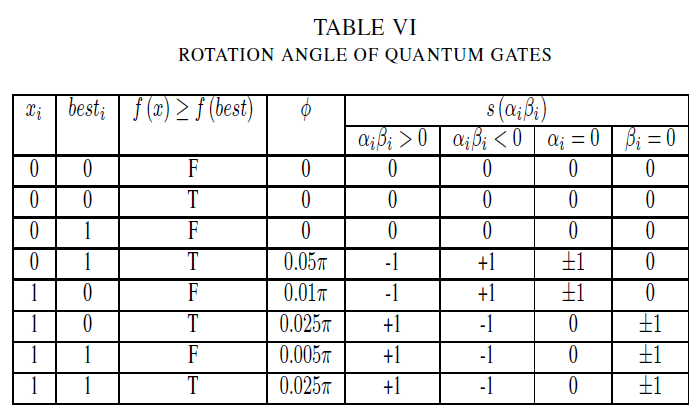

In [3]:
def rotate_qubits(qubits_list, current_binary_strings, best_binary_strings, current_accuracy, best_accuracy):

    def calculate_s_condition_1(alpha, beta):
        if alpha * beta > 0:
            return -1
        elif alpha * beta < 0:
            return 1
        elif alpha == 0:
            return np.random.choice([-1, 1])  # Random rotation direction
        elif beta == 0:
            return 0


    def calculate_s_condition_2(alpha, beta):
        if alpha * beta > 0:
            return 1
        elif alpha * beta < 0:
            return -1
        elif alpha == 0:
            return 0
        elif beta == 0:
            return np.random.choice([-1, 1])  # Random rotation direction


    rotated_qubits_list = []

    for layer_idx, qubit_layer in enumerate(qubits_list):
        rotated_layer = []

        for i, (alpha, beta) in enumerate(qubit_layer):
            xi = int(current_binary_strings[layer_idx][i])  # Use precomputed binary state
            best_i = int(best_binary_strings[layer_idx][i])  # Use precomputed binary state


            if xi == 0 and best_i == 1:
                if current_accuracy >= best_accuracy:
                    phi = 0.05 * np.pi
                    s = calculate_s_condition_1(alpha, beta)
                else:
                    phi = 0
                    s = 0

            elif xi == 1 and best_i == 0:
                if current_accuracy >= best_accuracy:
                    phi = 0.025 * np.pi
                    s = calculate_s_condition_2(alpha, beta)
                else:
                    phi = 0.01 * np.pi
                    s = calculate_s_condition_1(alpha, beta)

            elif xi == 1 and best_i == 1:
                if current_accuracy >= best_accuracy:
                    phi = 0.025 * np.pi
                    s = calculate_s_condition_2(alpha, beta)
                else:
                    phi = 0.005 * np.pi
                    s = calculate_s_condition_2(alpha, beta)

            elif xi == 0 and best_i == 0:
                phi = 0
                s = 0

            # Apply the rotation gate
            phi *= s
            new_alpha = alpha * np.cos(phi) - beta * np.sin(phi)
            new_beta = alpha * np.sin(phi) + beta * np.cos(phi)

            rotated_layer.append([new_alpha, new_beta])

        rotated_qubits_list.append(np.array(rotated_layer))

    return rotated_qubits_list




In [4]:
# To stop training if validation accuracy drops below (best_accuracy - threshold)
# after a certain fraction of total epochs, preventing unnecessary training when performance degrades.

class ThresholdEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, best_accuracy, threshold, start_epoch_fraction, total_epochs ):
        super(ThresholdEarlyStopping, self).__init__()
        self.best_accuracy = best_accuracy
        self.threshold = threshold
        self.start_epoch = int(start_epoch_fraction * total_epochs)

    def on_epoch_end(self, epoch, logs=None):
        # Apply threshold check only after fraction % of epochs
        if epoch + 1 >= self.start_epoch:
            current_val_accuracy = logs.get("val_sparse_categorical_accuracy")
            if current_val_accuracy is not None:
                if current_val_accuracy < self.best_accuracy - self.threshold:
                    print(
                        f"Epoch {epoch + 1}: Stopping training early. "
                        f"Current val accuracy ({current_val_accuracy:.4f}) is below the threshold."
                    )
                    self.model.stop_training = True


In [5]:
# To tabularise the final results for easy comparisson and understanding.

def summarize_results_and_best_model(best_results, num_classes, max_fc_layers):

    # Print the results in a table format
    print(f"{'Chromosome Index':<20}{'Accuracy':<15}{'Dot-Decimal List':<50}")
    print("=" * 90)

    for chrom_idx, result in best_results.items():
        print(f"{chrom_idx:<20}{result['accuracy']:<15.4f}{str(result['dot_decimal_list']):<50}")
        print(f"{'':<35}{', '.join(result['layer_types'])}")  # Indent layer types below dot-decimal list

    # Find the chromosome with the highest accuracy
    best_chrom_idx = max(best_results, key=lambda x: best_results[x]["accuracy"])
    best_chrom_data = best_results[best_chrom_idx]

    best_dot_decimal_list = best_chrom_data["dot_decimal_list"]
    print(f"\nChromosome {best_chrom_idx} is selected as the best chromosome.")

    # Construct the CNN model for the best chromosome
    best_cnn_model = construct_cnn_from_dot_decimal(best_dot_decimal_list, num_classes,max_fc_layers)

    print("\nSummary of the Best CNN Model:")
    best_cnn_model.summary()

    # Extract and print the layer parameters for the best CNN
    print("\nLayer Parameters of the Best CNN Model:")
    for idx, dot_decimal_value in enumerate(best_dot_decimal_list):
        binary_string, layer_type = dot_decimal_to_binary_and_layer(dot_decimal_value)
        if layer_type == "Conv":
            # Decode Conv Layer parameters
            filter_size = int(binary_string[:3], 2) + 1  # Range: 1-8
            feature_maps = int(binary_string[3:10], 2) + 1  # Range: 1-128
            stride_size = int(binary_string[10:], 2) + 1  # Range: 1-4
            print(f"Layer {idx + 1} - {layer_type}: Filter Size={filter_size}, Feature Maps={feature_maps}, Stride Size={stride_size}")
        elif layer_type == "Pooling":
            # Decode Pooling Layer parameters
            kernel_size = int(binary_string[:2], 2) + 1  # Range: 1-4
            stride_size = int(binary_string[2:4], 2) + 1  # Range: 1-4
            pool_type = int(binary_string[4:5], 2) + 1  # 1: MaxPooling, 2: AvgPooling
            print(f"Layer {idx + 1} - {layer_type}: Kernel Size={kernel_size}, Stride Size={stride_size}, Pool Type={'MaxPooling' if pool_type == 1 else 'AvgPooling'}")
        elif layer_type == "FC":
            # Decode Fully Connected Layer parameters
            neurons = int(binary_string, 2) + 1  # Range: 1-2048
            print(f"Layer {idx + 1} - {layer_type}: Neurons={neurons}")
        elif layer_type == "Disabled":
            print(f"Layer {idx + 1} - {layer_type}: Disabled Layer")


In [6]:

def construct_cnn_from_dot_decimal(dot_decimal_list, num_classes,max_fc_layers):
    fc_flag = False
    fc_layer_count = sum(1 for dd in dot_decimal_list if dot_decimal_to_binary_and_layer(dd)[1] == "FC")
    fc_index = 0  # Track FC layer index to ensure decreasing neurons

    model = tf.keras.Sequential()
    input_shape = (250, 250, 3)  # Input shape for potato images data set
  
    # Add input layer
    model.add(tf.keras.layers.InputLayer(input_shape=input_shape))

    for dot_decimal_value in dot_decimal_list:
        # Convert dot-decimal to binary and identify layer type
        binary_string, layer_type = dot_decimal_to_binary_and_layer(dot_decimal_value)

        if layer_type == "Conv":
            # Decode Conv Layer parameters with constraints
            filter_size = max(int(binary_string[:3], 2) + 1, 2)  # Range: 2-8
            feature_maps = int(binary_string[3:10], 2) + 1  # Range: 1-128
            stride_size = max(min(int(binary_string[10:], 2) + 1, 3), 1)  # Restrict stride to 1, 2, or 3

            # Ensure stride size does not exceed filter size
            stride_size = min(stride_size, filter_size)

            # Add Convolutional Layer
            model.add(tf.keras.layers.Conv2D(
                filters=feature_maps, 
                kernel_size=filter_size, 
                strides=stride_size, 
                activation="relu", 
                padding="same",
                kernel_initializer=HeNormal(),   # He Initialization (best for ReLU)
                kernel_regularizer=l2(0.001)    # L2 Regularization (adjust as needed)
            ))
            model.add(BatchNormalization())

        elif layer_type == "Pooling":
            # Decode Pooling Layer parameters with constraints
            kernel_size = max(int(binary_string[:2], 2) + 1, 2)  # Range: 2-4 (Min 2, not 1)
            stride_size = max(min(int(binary_string[2:4], 2) + 1, 3), 1)  # Restrict stride to 1, 2, or 3
            pool_type = int(binary_string[4:5], 2) + 1  # 1: MaxPooling, 2: AvgPooling

            # Ensure stride size does not exceed kernel size
            stride_size = min(stride_size, kernel_size)

            # Add Pooling Layer
            if pool_type == 1:
                model.add(tf.keras.layers.MaxPooling2D(pool_size=kernel_size, strides=stride_size, padding="same"))
            elif pool_type == 2:
                model.add(tf.keras.layers.AveragePooling2D(pool_size=kernel_size, strides=stride_size, padding="same"))
            else:
                raise ValueError(f"Unexpected pool type: {pool_type}")

            model.add(BatchNormalization())

        elif layer_type == "FC":
            if not fc_flag:
                # Find last Conv/Pooling layer before FC layers
                for prev_layer in reversed(model.layers):
                    if isinstance(prev_layer, (tf.keras.layers.Conv2D, tf.keras.layers.MaxPooling2D, tf.keras.layers.AveragePooling2D)):
                        last_layer_shape = prev_layer.output.shape
                        break
        
                # Flatten the last valid layer
                model.add(tf.keras.layers.Flatten())
                fc_flag = True  # Mark that FC layer has been introduced
        
                # Compute max neurons from flattened layer
                N0 = np.prod(last_layer_shape[1:])  # Initial neurons
                scaling_factor = 2048 / N0 if N0 > 2048 else 1  # Scale down if >2048
                N0 = int(N0 * scaling_factor)  # Reduce neuron count proportionally
                print("scaled N0= ",N0)
                Nn = num_classes  # Final neurons (output layer size)
                n = max_fc_layers  # Total FC layers
        
                # Ensure at least 2 layers to avoid division by zero
                if n > 1:
                    decrement = (N0 - Nn) / (n)
                    print("decrement= ",decrement)
                else:
                    decrement = 0  # In case there's only one FC layer
        
            # Compute neurons for current FC layer using the formula
            neurons = int(N0 - ((fc_index ) * decrement))
            print("nuerons= ",neurons)

            # Add Fully Connected Layer with Batch Normalization and Dropout
            #model.add(tf.keras.layers.Dense(neurons, use_bias=False))
            model.add(tf.keras.layers.Dense(neurons, 
                                use_bias=False, 
                                kernel_regularizer=l2(0.001),  # L2 Regularization
                                kernel_initializer=HeNormal())
                     )  # Proper Weight Initialization

            # Apply Dropout **only after the first FC layer**
            if fc_index > 0:  # Skip dropout for the first FC layer
                model.add(tf.keras.layers.Activation("relu"))
                model.add(Dropout(0.5))  # Apply Dropout only from the second FC layer onward
            else:
                model.add(tf.keras.layers.Activation("relu"))  # No Dropout for the first FC layer
        
            fc_index += 1  # Move to the next FC layer

        elif layer_type == "Disabled":
            # Skip Disabled Layers
            continue

    # Add the final output layer with the number of classes
    model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))  # Output layer
    return model


def train_cnn_model(model, epochs, batch_size, learning_rate, best_accuracy, threshold, start_epoch_fraction):
    """
    Train a CNN model for your Dataset.
    """
    # Training: Data Augmentation + Rescaling
    train_dir = r"/Path_to_dataset/Training"
    val_dir = r"/Path_to_dataset/Validation"
    test_dir = r"/Path_to_dataset/Testing"
    
    # For Data augmentation
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=40, 
        width_shift_range=0.2,  
        height_shift_range=0.2,  
        shear_range=0.15,  
        zoom_range=0.2,  
        horizontal_flip=True,  
        fill_mode='nearest'  # Nearest neighbor filling for missing pixels during transformations
    )
        
    # Validation & Test: Only Rescaling
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    # Train Generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode="sparse",
        shuffle=True  # Shuffle training data
    )
    
    # Validation Generator (Separate Folder)
    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(250, 250),
        batch_size=batch_size,        
        class_mode="sparse",
        shuffle=False  # No shuffling for validation
    )
    
    # Test Generator (Separate Folder)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(250, 250),
        batch_size=batch_size,
        class_mode="sparse",
        shuffle=False  # No shuffling for test
    )


    # Define optimizer, loss, and metrics
    optimizer = Adam(learning_rate=0.001)
    loss_fn = SparseCategoricalCrossentropy()
    metric = SparseCategoricalAccuracy()

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=[metric])

    # Early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=int(start_epoch_fraction * epochs),
        restore_best_weights=True
    )

    # Train the model
    start_time = time.time()  # Start the timer
    print("Training started...")

    history = model.fit(
        train_generator,  
        epochs=epochs,
        batch_size=batch_size,
        validation_data=validation_generator,
        callbacks=[early_stopping],
        verbose=1
    )
    end_time = time.time()  # End the timer
    training_time = end_time - start_time  # Calculate duration
    print(f"Training completed in {training_time:.2f} seconds.")

    # Evaluate on the test set
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

    return history




In [7]:
def plot_training_history(history):
    
    """
    Plots training and validation accuracy vs epochs and training and validation loss vs epochs
    using the training history.
    """
    
    train_acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(train_acc) + 1)
        
    # Plot accuracy
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Plot the training history (accuracy and loss vs epochs)


In [8]:
# to train the best CNN form the population.

def train_best_chromosome(best_chromosome_data, num_classes, epochs, batch_size, learning_rate, threshold , start_epoch_fraction,max_fc_layers):
    
    # Extract the dot-decimal list of the best chromosome
    dot_decimal_list = best_chromosome_data['dot_decimal_list']

    # Reconstruct the best CNN model from the dot-decimal list
    print("\nReconstructing the Best Chromosome...")
    best_cnn_model = construct_cnn_from_dot_decimal(dot_decimal_list, num_classes,max_fc_layers)
    

    # Train the best chromosome using `train_cnn_model`
    print(f"\nTraining the Best Chromosome for {epochs} additional epochs...")
    history = train_cnn_model(
        best_cnn_model,
        epochs=epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        best_accuracy=best_chromosome_data['accuracy'],
        threshold=threshold,
        start_epoch_fraction=start_epoch_fraction
    )

        # Print final results
    final_val_accuracy = history.history['val_sparse_categorical_accuracy'][-1]
    print(f"Final Validation Accuracy After Training the Best Chromosome: {final_val_accuracy:.4f}")

    # Extract accuracy values
    train_acc = history.history.get('sparse_categorical_accuracy', [])
    val_acc = history.history.get('val_sparse_categorical_accuracy', [])

    # Convert accuracy values to percentage
    train_acc = [acc * 100 for acc in train_acc]
    val_acc = [acc * 100 for acc in val_acc]

    # Check if values exist before plotting
    if len(train_acc) == 0 or len(val_acc) == 0:
        print("Warning: Accuracy data is empty. Skipping plot.")
        return history, best_cnn_model

    # Plot Training and Validation Accuracy
    plt.figure()
    #plt.ylim(50, 100)  # Set y-axis from 0 to 100%
    plt.plot(train_acc, label='Training Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='s')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Training Epochs (Best Chromosome)')
    plt.legend()    
    plt.savefig(f'{name_stamp}_TEST_accuracy_vs_epochs_best_{int(time.time())}.svg', format='svg')
    plt.show()
    plt.close()



    return history, best_cnn_model

In [9]:
def save_experiment_results( all_iterations, all_accuracies, chromosome_labels,best_history, 
                            additional_epochs, num_classes, best_results, filename=None):
    
    # Extract accuracy per epoch for best chromosome
    best_train_acc = best_history.history.get('sparse_categorical_accuracy', [])
    best_val_acc = best_history.history.get('val_sparse_categorical_accuracy', [])

    # Convert accuracy values to percentage
    best_train_acc = [float(acc) * 100 for acc in best_train_acc]
    best_val_acc = [float(acc) * 100 for acc in best_val_acc]

    # Convert best_results (excluding qubits) into JSON-friendly format
    processed_best_results = {
        chrom_idx: {
            "accuracy": float(data["accuracy"]) * 100,  # Convert to percentage
            "dot_decimal_list": data["dot_decimal_list"],  # Already a list
            "layer_types": data["layer_types"]  # Already a list
        }
        for chrom_idx, data in best_results.items()
    }

    # Create a dictionary to store the results
    experiment_data = {
        "accuracy_vs_iterations": {
            "iterations": all_iterations,
            "accuracies": [acc * 100 for acc in all_accuracies],  # Convert to percentage
            "chromosome_labels": chromosome_labels
        },
        "best_chromosome_training": {
            "train_accuracy": best_train_acc,
            "val_accuracy": best_val_acc,
            "epochs": additional_epochs,
            "num_classes": num_classes
        },
        "best_results_per_chromosome": processed_best_results
    }

    # If no filename is provided, generate a default one with a timestamp
    if filename is None:
        timestamp = int(time.time())
        filename = f"qiea_experiment_{timestamp}.json"

    # Save to JSON file
    with open(filename, "w") as json_file:
        json.dump(experiment_data, json_file, indent=4)

    print(f"\n Experiment results saved to: {filename}")


In [10]:


def main():
    setup_gpu()   #Configures TensorFlow to use GPU efficiently by enabling memory growth.
    main_start_time=time.time()
    """
    Main function to control the entire process of initialization, CNN training, and qubit rotation.
    """
    # Parameters
    population_size = 10  # Number of chromosomes in the population
    training_itration = 25  # Number of training and rotation iterations per chromosome
    epochs_per_training = 15 # Number of epochs for training each CNN model--refred in threshold stopping alsoo
    batch_size =  16 # Batch size for training
    learning_rate = 0.01  # Learning rate for the optimizer
    max_layers = 8   # Maximum CNN layers
    max_fc_layers = 2  # Maximum fully connected layers
    num_classes = 3  # Number of output classes for CIFAR-10
    additional_epochs = 50  # Define the additional epochs
    train_cnn_threshold=0.01    #for early stopping while training CNN  if current_val_accuracy < self.best_accuracy - self.threshold:
    start_epoch_fraction=0.8   # for early stopping the citeria ccheck after only 80 percentage of epochs are finished
    stop_itration_threshold = 5  # Stop if accuracy does not improve for x iterations if current accuracy< best accurecy no improvment ++ then if no imprvment > stop itrrrrrrrrrrrrrrrrr
    manual_layer_types = ['Conv','Pooling','Conv', 'Pooling','Conv','Pooling', 'FC', 'FC']  # Optional
    # manual_layer_types = []

    # Initialize lists for plotting
    all_iterations = []  # Stores iteration numbers
    all_accuracies = []  # Stores corresponding accuracy values
    chromosome_labels = []  # Stores chromosome numbers
    
    
    # Initialize the population
    population = []
    for chrom_idx in range(population_size):
        if chrom_idx == 0 and manual_layer_types:  # Assign manual layers to the first chromosome if provided
            chromosome = QuantumChromosome(
                max_layers=max_layers,
                num_classes=num_classes,
                max_fc_layers=max_fc_layers,
                manual_layer_types=manual_layer_types
            )
            print(f"Chromosome {chrom_idx + 1} initialized with manual layers.")
        else:  # Random initialization for the rest
            chromosome = QuantumChromosome(
                max_layers=max_layers,
                num_classes=num_classes,
                max_fc_layers=max_fc_layers
            )
            print(f"Chromosome {chrom_idx + 1} initialized randomly.")
        population.append(chromosome)

    print(f"\nInitialized {population_size} Chromosomes.")


    best_results = {}
    # Iterate over each chromosome
    for chrom_idx, chromosome in enumerate(population, start=1):
        print(f"\nProcessing Chromosome {chrom_idx}/{population_size}...")
        best_accuracy = 0  # Variable to store the best accuracy for this chromosome
        best_qubits = chromosome.qubits_list  # Store the best qubits configuration
        no_improvement_count = 0  # Counter for iterations with no improvement

        # Perform rotations and training iteratively
        for itration in range(training_itration):
            print(f"\nIteration {itration + 1} for Chromosome {chrom_idx}...")
            print("Dot decimal list ",chromosome.dot_decimal_list)

            # Extract and print layer types
            current_layer_types = [dot_decimal_to_binary_and_layer(dd)[1] for dd in chromosome.dot_decimal_list]
            print("Layer types:", current_layer_types)

            # Decode dot-decimal list into CNN
            cnn_model = construct_cnn_from_dot_decimal(chromosome.dot_decimal_list, num_classes,max_fc_layers)

            # Train the CNN model
            print("Training CNN Model...")

            # Define the early stopping callback

            history = train_cnn_model(
                cnn_model,
                epochs=epochs_per_training,
                batch_size=batch_size,
                learning_rate=learning_rate,
                best_accuracy=best_accuracy,
                threshold= train_cnn_threshold,
                start_epoch_fraction=start_epoch_fraction
            )

            #print("history.history.keys():", history.history.keys())
            # Get the last 3 validation accuracies
            current_accuracy = max(history.history['val_sparse_categorical_accuracy'][-3:])
            print(f"Iteration {itration + 1} Accuracy: {current_accuracy:.4f}")
            
            plot_training_history(history)
            
            # Store data for plotting
            all_iterations.append(itration + 1)
            all_accuracies.append(current_accuracy * 100)
            chromosome_labels.append(chrom_idx)

            # Update the best accuracy and qubits configuration if better
            if current_accuracy > best_accuracy:
                best_accuracy = current_accuracy
                best_qubits = chromosome.qubits_list.copy()  # Save the best qubits configuration
                best_dot_decimal_list = chromosome.dot_decimal_list.copy()  # Save the best dot-decimal list
                best_cnn_model = cnn_model  # Save the best CNN model
                best_layer_type = current_layer_types
                no_improvement_count =0  # REset counter
                print(f"New Best Accuracy for Chromosome {chrom_idx}: {best_accuracy:.4f}")
            else:
                no_improvement_count += 1
                if no_improvement_count >= stop_itration_threshold:
                    print(f"No improvement for {stop_itration_threshold} iterations. Stopping training.")
                    break
            

            # Extract binary strings from the best dot-decimal list
            best_binary_strings = [
                dot_decimal_to_binary_and_layer(dd)[0]  # Extract binary string
                for dd in best_dot_decimal_list
            ]

            # Rotate the qubits using precomputed binary strings
            chromosome.qubits_list = rotate_qubits(
                qubits_list=chromosome.qubits_list,
                current_binary_strings=chromosome.binary_strings_list,
                best_binary_strings=best_binary_strings,
                current_accuracy=current_accuracy,
                best_accuracy=best_accuracy
            )

            # Update binary strings after rotation
            chromosome.binary_strings_list = [
                ''.join('0' if abs(alpha)**2 > abs(beta)**2 else '1' for alpha, beta in qubit_layer)
                for qubit_layer in chromosome.qubits_list
            ]

            # Update dot-decimal list after rotation
            new_dot_decimal_list = []
            for qubit_layer, dot_decimal_value in zip(chromosome.qubits_list, chromosome.dot_decimal_list):
                # Extract the layer type from the previous dot-decimal value
                layer_type = dot_decimal_to_binary_and_layer(dot_decimal_value)[1]

                # Generate binary string based on the rotated qubits
                binary_string = ''.join(
                    '0' if abs(alpha)**2 > abs(beta)**2 else '1'
                    for alpha, beta in qubit_layer
                )

                # Convert binary string to dot-decimal
                dot_decimal_value = binary_to_dot_decimal(binary_string, layer_type)

                # Append the updated dot-decimal value
                new_dot_decimal_list.append(dot_decimal_value)

            # Update the chromosome's dot-decimal list
            chromosome.dot_decimal_list = new_dot_decimal_list

            # Clear the model to free up memory
            from keras import backend as K
            del cnn_model
            K.clear_session()
            time.sleep(20)
            gc.collect()

        # end of qubit rotation loop

        # Update the best_results dictionary for the current chromosome
        best_results[chrom_idx] = {
            "accuracy": best_accuracy,
            "qubits": best_qubits,  # Store the best qubits configuration
            "dot_decimal_list": best_dot_decimal_list,  # Store the best dot-decimal list
            "layer_types": best_layer_type,  # Store the best layer types
        }

        # Save partial results after each chromosome completes
        save_experiment_results(
            all_iterations=all_iterations,
            all_accuracies=all_accuracies,
            chromosome_labels=chromosome_labels,
            best_history=history,  # If it's not the best, you can pass None
            additional_epochs=epochs_per_training,  # Current training epochs
            num_classes=num_classes,
            best_results=best_results,
            filename=f"{name_stamp}_partial_qiea_results_chromosome.json"
           
        )


    # End of population loop

    print("\nAll Chromosomes Processed.")
    summarize_results_and_best_model(best_results, num_classes, max_fc_layers)
    
    # After the main evolutionary algorithm finishes, select the best chromosome
    best_chromosome_data = best_results[max(best_results, key=lambda x: best_results[x]["accuracy"])]

    # Train the best chromosome for additional epochs
    
    best_history, best_trained_model = train_best_chromosome(
        best_chromosome_data=best_chromosome_data,
        num_classes= num_classes,  # Update based on your dataset
        epochs=additional_epochs,
        batch_size=batch_size,  # Use the same batch size as in the main function
        learning_rate= learning_rate,
        threshold=float('inf'),  # Disable early stopping by setting a high threshold
        start_epoch_fraction=1.1,
        max_fc_layers = max_fc_layers
        )

    # Extract and print the final validation accuracy
    if 'val_accuracy' in best_history.history:
        final_val_accuracy = best_history.history['val_accuracy'][-1]
        print(f"Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")
    else:
        print("Validation accuracy not found in training history.")
    main_end_time=time.time()
    main_time_difference= main_end_time - main_start_time
    # Display the results
    print(f"\nStart Time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(main_start_time))}")
    print(f"End Time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(main_end_time))}")
    # Convert seconds to hours, minutes, and seconds
    hours = int(main_time_difference // 3600)
    minutes = int((main_time_difference % 3600) // 60)
    seconds = main_time_difference % 60
    
    # Print the formatted time
    print(f"Total Execution Time: {hours} hour(s), {minutes} minute(s), and {seconds:.2f} second(s)")

    print(f"Total Execution Time: {main_time_difference:.2f} seconds")

    #print("Iteration Numbers:", all_iterations)
    #print("Accuracy Values (%):", all_accuracies)
    #print("Chromosome Labels:", chromosome_labels)
    
    #-------------------------------------------------------------------------------------------
    # Plot Accuracy vs. Iterations (All Chromosomes)
    plt.figure()
    #plt.ylim(0, 100)  # Set y-axis from 0 to 100%
    
    # Define a dictionary to map each chromosome to a unique marker
    unique_markers = ['o', 's', 'D', '^', 'v', 'p', '*', 'X', 'P', 'H']
    chromosome_marker_map = {chrom: unique_markers[chrom % len(unique_markers)] for chrom in set(chromosome_labels)}
    
    for i in range(len(all_iterations)):
        plt.scatter(
            all_iterations[i], all_accuracies[i],
            color=f'C{chromosome_labels[i] % 10}',  # Assigning unique colors
            marker=chromosome_marker_map[chromosome_labels[i]],  # Assigning unique marker
            label=f'Chromosome {chromosome_labels[i]}' if all_iterations[i] == 1 else ""
        )
    
    plt.xlabel('Iteration Number')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Number of Iterations (All Chromosomes)')
    plt.legend()
    plt.savefig(f'{name_stamp}_test_accuracy_vs_iterations_run_marker_{int(time.time())}.svg', format='svg')  # Unique filename for each run
    plt.show()
    plt.close()
    #--------------------------------------------------------------------
    # For line graph
    plt.figure()
    
    # Define unique colors for each chromosome
    unique_colors = [f'C{i % 10}' for i in range(10)]  # Use 10 different colors
    
    # Group iterations and accuracies by chromosome
    chromosome_data = {}
    for i in range(len(all_iterations)):
        chrom = chromosome_labels[i]
        if chrom not in chromosome_data:
            chromosome_data[chrom] = {"iterations": [], "accuracies": []}
        chromosome_data[chrom]["iterations"].append(all_iterations[i])
        chromosome_data[chrom]["accuracies"].append(all_accuracies[i])
    
    # Plot a line for each chromosome with a unique color (No Markers)
    for idx, (chrom, data) in enumerate(chromosome_data.items()):
        plt.plot(
            data["iterations"], data["accuracies"],
            color=unique_colors[idx % len(unique_colors)],  # Assign unique color
            label=f'Chromosome {chrom}'
        )
    
    plt.xlabel('Iteration Number')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Number of Iterations (All Chromosomes)')
    plt.legend()
    plt.savefig(f'{name_stamp}_test_accuracy_vs_iterations_run_lineGraph_{int(time.time())}.svg', format='svg')  # Unique filename for each run
    plt.show()
    plt.close()

    save_experiment_results( all_iterations, all_accuracies, chromosome_labels,best_history, 
                            additional_epochs, num_classes, best_results, filename= f"{name_stamp}_SVAE_DATA.json"
                           )
    print("Program Completed.")

    exit()
    
name_stamp= "05_Potato"

if __name__ == "__main__":
    main()



Num GPUs Available:  0
Chromosome 1 initialized with manual layers.
Chromosome 2 initialized randomly.
Chromosome 3 initialized randomly.
Chromosome 4 initialized randomly.
Chromosome 5 initialized randomly.
Chromosome 6 initialized randomly.
Chromosome 7 initialized randomly.
Chromosome 8 initialized randomly.
Chromosome 9 initialized randomly.
Chromosome 10 initialized randomly.

Initialized 10 Chromosomes.

Processing Chromosome 1/10...

Iteration 1 for Chromosome 1...
Dot decimal list  [13.251, 17.45, 0.213, 18.203, 2.239, 23.183, 28.249, 31.159]
Layer types: ['Conv', 'Pooling', 'Conv', 'Pooling', 'Conv', 'Pooling', 'FC', 'FC']


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


flatten N0=  240
scaled N0=  240
decrement=  118.5
nuerons=  240
nuerons=  121
Training CNN Model...


FileNotFoundError: [WinError 3] The system cannot find the path specified: '/home/test2/qiea/03_potato/Potato_dataset/Training'